In [37]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [38]:
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
         mean=[0.5],
         std=[0.5]
        )
    ]
)

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

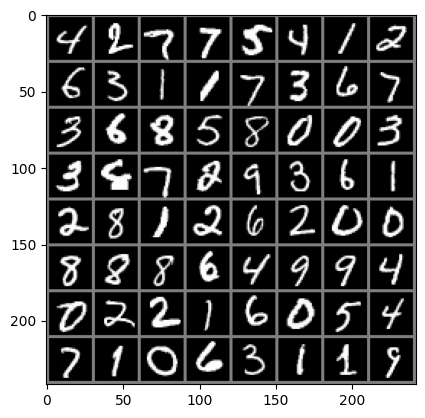

Shape of a batch of images: torch.Size([64, 1, 28, 28])


In [39]:
# cell-3
def imshow(img):
    img = img / 2 + 0.5  # Denormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    # npimg has a shape of (channels, height, width), this transposition changes it to (height, width, channels)
    # this is typically done because image processing libraries (like Matplotlib or OpenCV) expect images in the (height, width, channels)
    plt.show()

def show_grid(images):
    img_grid = torchvision.utils.make_grid(images, nrow=8)
    imshow(img_grid)

# Get some random training images
trainloader_for_vis = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
dataiter = iter(trainloader_for_vis)
images, labels = next(dataiter)

# Display the images in a grid
show_grid(images)

print(f"Shape of a batch of images: {images.shape}")

<p>out = (I - 1) × stride + kernel size - 2 × padding</p>

In [40]:

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 28 x 28
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1), # (64,14,14)
            nn.LeakyReLU(0.2,inplace=True),
            self._block(features_d, features_d * 2, 4, 2, 1),  # (32,7,7)
            nn.Conv2d(features_d * 2, 1, kernel_size=7, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2,inplace=True),
        )

    def forward(self, x):
        return self.disc(x)

In [41]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # (features_g * 16, 4, 4)
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  #(features_g * 8, 8, 8)
            self._block(features_g * 8, features_g * 4, 4, 2, 1),   #(features_g * 4, 16, 16)
            nn.ConvTranspose2d(
                features_g * 4, channels_img, kernel_size=4, stride=2, padding=3  #(1, 28, 28)
            ),

            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [43]:
latent_dim = 100 # Size of z latent vector (i.e. size of generator input)

channels_img=1 # Number of channels in the training images.

features_g = 64  # number of feature maps in generator

features_d = 64 # number of feature maps in discriminator

# Initialize Generator and Discriminator
generator = Generator(latent_dim , channels_img, features_g)
discriminator = Discriminator(channels_img,features_d)


In [44]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


In [45]:
#Initialize weights
generator.apply(initialize_weights)
discriminator.apply(initialize_weights)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Conv2d(128, 1, kernel_size=(7, 7), stride=(2, 2))
    (4): Sigmoid()
  )
)

In [46]:
# Move models to device
generator.to(device)
discriminator.to(device)

# creating binary cross entropy loss instance
criterion = nn.BCELoss()

# creating optimizers for generator and discriminator
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001)

In [47]:
# Containers to store losses for visualization purpose
num_epochs = 20
discriminator_loss = []
generator_loss = []

Epoch [1/20], Step [200/3750], d_loss: 0.2944, g_loss: 2.0972, D(x): 0.87, D(G(z)): 0.14
Epoch [1/20], Step [400/3750], d_loss: 0.5396, g_loss: 1.7626, D(x): 0.79, D(G(z)): 0.25
Epoch [1/20], Step [600/3750], d_loss: 0.4298, g_loss: 1.8077, D(x): 0.82, D(G(z)): 0.21
Epoch [1/20], Step [800/3750], d_loss: 0.7743, g_loss: 1.1701, D(x): 0.66, D(G(z)): 0.27
Epoch [1/20], Step [1000/3750], d_loss: 0.6481, g_loss: 1.3190, D(x): 0.75, D(G(z)): 0.29
Epoch [1/20], Step [1200/3750], d_loss: 0.7889, g_loss: 1.0992, D(x): 0.70, D(G(z)): 0.32
Epoch [1/20], Step [1400/3750], d_loss: 1.0024, g_loss: 0.7795, D(x): 0.67, D(G(z)): 0.44
Epoch [1/20], Step [1600/3750], d_loss: 0.6517, g_loss: 1.5611, D(x): 0.71, D(G(z)): 0.21
Epoch [1/20], Step [1800/3750], d_loss: 0.7599, g_loss: 1.4762, D(x): 0.71, D(G(z)): 0.31
Epoch [1/20], Step [2000/3750], d_loss: 0.7149, g_loss: 1.5633, D(x): 0.76, D(G(z)): 0.29
Epoch [1/20], Step [2200/3750], d_loss: 0.8909, g_loss: 1.1244, D(x): 0.71, D(G(z)): 0.38
Epoch [1/20], 

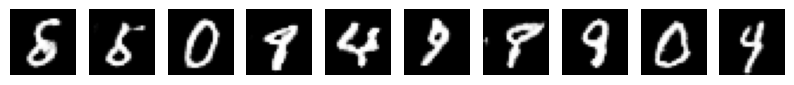

Epoch [11/20], Step [200/3750], d_loss: 1.1260, g_loss: 0.8989, D(x): 0.56, D(G(z)): 0.37
Epoch [11/20], Step [400/3750], d_loss: 0.8510, g_loss: 1.3308, D(x): 0.75, D(G(z)): 0.40
Epoch [11/20], Step [600/3750], d_loss: 1.1584, g_loss: 0.7381, D(x): 0.60, D(G(z)): 0.44
Epoch [11/20], Step [800/3750], d_loss: 1.1204, g_loss: 0.8894, D(x): 0.63, D(G(z)): 0.45
Epoch [11/20], Step [1000/3750], d_loss: 0.7683, g_loss: 0.8587, D(x): 0.66, D(G(z)): 0.25
Epoch [11/20], Step [1200/3750], d_loss: 1.1409, g_loss: 0.8518, D(x): 0.60, D(G(z)): 0.43
Epoch [11/20], Step [1400/3750], d_loss: 1.2129, g_loss: 1.0785, D(x): 0.75, D(G(z)): 0.57
Epoch [11/20], Step [1600/3750], d_loss: 0.7033, g_loss: 1.5727, D(x): 0.67, D(G(z)): 0.22
Epoch [11/20], Step [1800/3750], d_loss: 1.2321, g_loss: 0.5506, D(x): 0.72, D(G(z)): 0.55
Epoch [11/20], Step [2000/3750], d_loss: 1.1577, g_loss: 1.3481, D(x): 0.60, D(G(z)): 0.44
Epoch [11/20], Step [2200/3750], d_loss: 1.0822, g_loss: 1.5391, D(x): 0.48, D(G(z)): 0.24
Epo

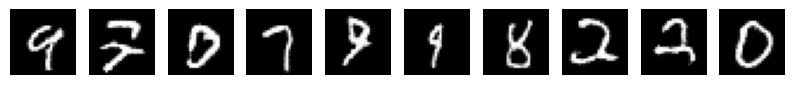

In [48]:
for epoch in range(num_epochs):
    d_epoch_loss = 0
    g_epoch_loss = 0
    for i, (images, _) in enumerate(trainloader):
        batch_size = images.size(0)  #([64, 1, 28, 28]) ---> 64
        images = images.to(device)

        # Create labels for training discriminator and generator
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ====================================================================
        # TRAINING DISCRIMINATOR
        # ====================================================================
        # Step1: Infer the discriminator on real images

        discriminator.train()

        outputs = discriminator(images)

        outputs = outputs.squeeze().unsqueeze(dim=1) # converting format [[[[0.34]]]] ---> [[0.43]]

        # Step2: Calculate the loss with real labels
        d_real_data_loss = criterion(outputs, real_labels)
        real_score = outputs

        # Step3: Generate random latent vectors from normal distribution
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)

        # Step4: Generate fake images by passing latent vector to generator
        fake_images = generator(z)

        # Step5: Infer the discriminator on fake images
        outputs = discriminator(fake_images)
        outputs = outputs.squeeze().unsqueeze(dim=1)

        # Step6: Calculate the loss with fake labels
        d_fake_data_loss = criterion(outputs, fake_labels)
        fake_score = outputs

        # Step7: Calculate the total loss
        d_loss = d_real_data_loss + d_fake_data_loss
        d_epoch_loss += d_loss.item()

        # Step8: Update the weights
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()


        # ====================================================================
        # TRAINING GENERATOR
        # ====================================================================

        generator.train()

        # Step1: Generate random latent vectors from normal distribution
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)

        # Step2: Generate fake images by passing latent vector to generator
        fake_images = generator(z)

        # Step3: Infer the discriminator on fake images
        outputs = discriminator(fake_images)
        outputs = outputs.squeeze().unsqueeze(dim=1)

        g_loss = criterion(outputs, real_labels)

        g_epoch_loss += g_loss.item()

        # Step5: Update the weights
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        if (i + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    generator_loss.append(g_epoch_loss / len(trainloader))
    discriminator_loss.append(d_epoch_loss / len(trainloader))

    # Visualize the intermediate results
    if (epoch + 1) % 10 == 0:
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        fake_images = fake_images.detach().cpu().numpy()

        fig, ax = plt.subplots(1, 10, figsize=(10, 1))
        for i in range(10):
            ax[i].imshow(fake_images[i, 0], cmap='gray')
            ax[i].axis('off')
        plt.show()

In [49]:
torch.save(generator, 'generator.pt')
torch.save(discriminator, 'discriminator.pt')

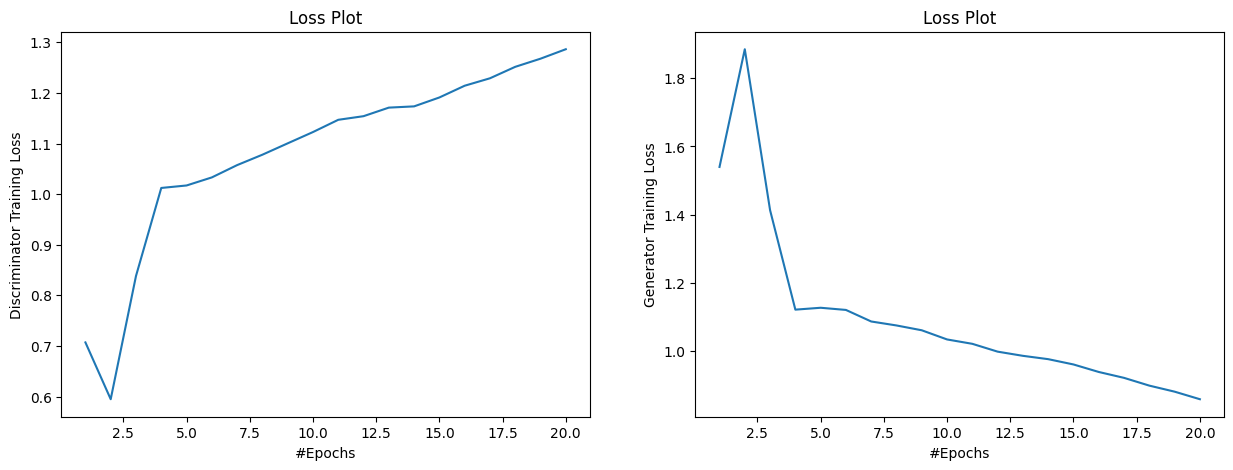

In [50]:

plt.figure(figsize=(15, 5))

# Subplot for discriminator and generator loss
plt.subplot(1, 2, 1)
plt.title("Loss Plot")
train_num_epoch = [i + 1 for i in range(len(discriminator_loss))]
plt.plot(train_num_epoch, discriminator_loss)
plt.xlabel("#Epochs")
plt.ylabel("Discriminator Training Loss")

plt.subplot(1, 2, 2)
plt.title("Loss Plot")
train_num_epoch = [i + 1 for i in range(len(discriminator_loss))]
plt.plot(train_num_epoch, generator_loss)
plt.xlabel("#Epochs")
plt.ylabel("Generator Training Loss")
plt.show()

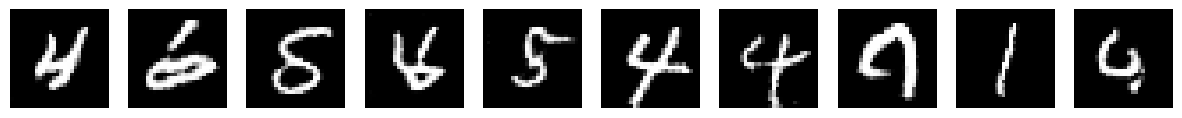

In [52]:

# Load the model
generator = torch.load('generator.pt')

# Set the generator to evaluation mode
generator.eval()

# Generate latent vectors
num_samples = 10
input_noise = torch.randn(num_samples, latent_dim,1,1).to(device)

# Generate image using latent vectors
generated_samples = generator(input_noise)

generated_samples_np = generated_samples.detach().cpu().numpy()

# Visualize the generated samples
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axes[i].imshow(generated_samples_np[i, 0], cmap='gray')
    axes[i].axis('off')
plt.show()

In [ ]:

# Load the model
generator = torch.load('generator.pt')

# Set the generator to evaluation mode
generator.eval()

# Generate latent vectors
num_samples = 10
input_noise = torch.randn(num_samples, latent_dim,1,1).to(device)

# Generate image using latent vectors
generated_samples = generator(input_noise)

with torch.inference_mode:
  generated_samples_np = generated_samples.detach().cpu().numpy()

# Visualize the generated samples
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axes[i].imshow(generated_samples_np[i, 0], cmap='gray')
    axes[i].axis('off')
plt.show()

In [55]:
# Load the model
generator = torch.load('generator.pt')

# Set the generator to evaluation mode
generator.eval()

# Generate latent vectors
num_samples = 10
input_noise = torch.randn(num_samples, latent_dim,1,1).to(device)

# Generate image using latent vectors
generated_samples = generator(input_noise)

generated_samples

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.000

In [59]:
# Load the model
generator = torch.load('generator.pt')

# Set the generator to evaluation mode
generator.eval()

# Generate latent vectors
num_samples = 10
input_noise = torch.randn(num_samples, latent_dim,1,1).to(device)

# Generate image using latent vectors
generated_samples = generator(input_noise)

generated_samples.detach()

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -0.9999, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -0.9991, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9998, -0.9928, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -0.9982, -0.9993,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.9996,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -0.999

In [58]:
# Load the model
generator = torch.load('generator.pt')

# Set the generator to evaluation mode
generator.eval()

# Generate latent vectors
num_samples = 10
input_noise = torch.randn(num_samples, latent_dim,1,1).to(device)

# Generate image using latent vectors
with torch.inference_mode():
   generated_samples = generator(input_noise)

generated_samples

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.000

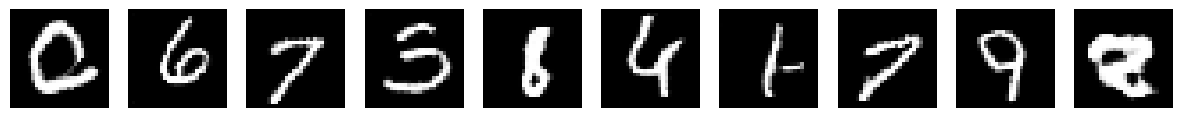

In [62]:

# Load the model
generator = torch.load('generator.pt')

# Set the generator to evaluation mode
generator.eval()

# Generate latent vectors
num_samples = 10
input_noise = torch.randn(num_samples, latent_dim,1,1).to(device)

# Generate image using latent vectors
generated_samples = generator(input_noise)

with torch.inference_mode():
  generated_samples_np = generated_samples.cpu().numpy()

# Visualize the generated samples
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axes[i].imshow(generated_samples_np[i, 0], cmap='gray')
    axes[i].axis('off')
plt.show()